In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tensorflow.keras.utils import img_to_array

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from skimage import transform
from skimage import exposure

import seaborn as sb
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

import random
import os

In [ ]:
def plot_class_percent_bar(fig, series_class_counts, 
                           title: str, xlabel: str, ylabel: str, fig_name: str,
                           fontsize: int=12,
                           color='lightseagreen', edgecolor='lightseagreen'):
    plt.tight_layout()
    plt.style.use(['classic'])  # 'classic' | 'dark_background'
    fig.set_facecolor('w')
    
    bars = series_class_counts.plot.bar(color=color, edgecolor=edgecolor)

    totals = []
    for bar in bars.patches:
        totals.append(bar.get_height())
    total = sum(totals)

    ymin, ymax = bars.get_ylim()
    bars.set_ylim(top=ymax*1.1)

    # set individual bar lables using above list
    for bar in bars.patches:
        bar_height = bar.get_height()
        plt.text(bar.get_x(), bar_height + ymax*0.02,
                str(round((bar_height/total)*100, 2)) + "%",
                fontsize=fontsize, color=color, rotation=90)
        
    plt.title(title, color='k', fontsize=20)
    plt.xlabel(xlabel, color='k', fontsize=16)
    plt.ylabel(ylabel, color='k', fontsize=16)
    try:
        fig.savefig(fig_name)
        print(f"Saved to the: {fig_name}")
    except Exception as e:
        print('ERROR: Unsuccessfull saving')
        print(e)

Examples of classes names of RTSD-r1:


,class_number,sign_class
0,0,1_1
1,1,1_11


,class_number,sign_class
65,65,4_2_3
66,66,4_3



Number of classes in RTSD-r1: 67
Shape of RTSD-r1 labels DataFrame: (25432, 2)
ERROR: Unsuccessfull saving
[Errno 2] No such file or directory: '/content/result/r1_base_en.png'


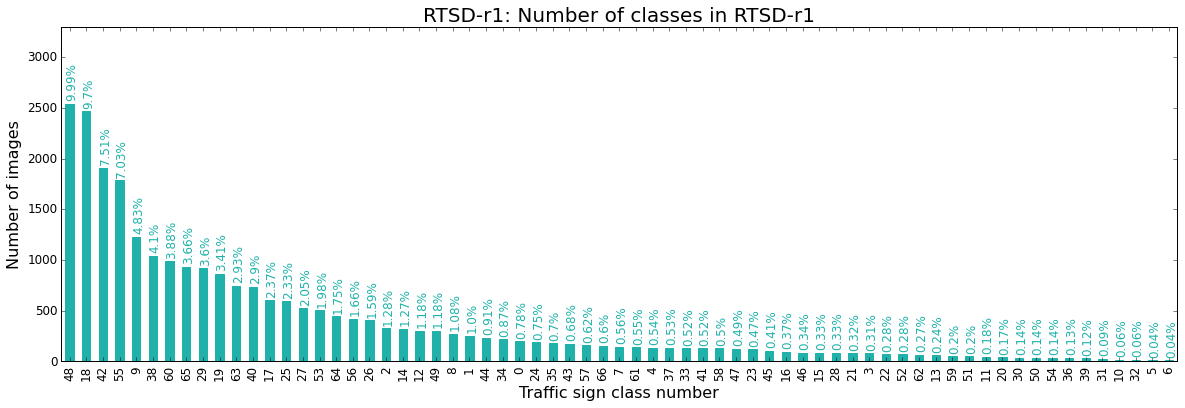

In [ ]:
results_path = '/content/result'
r1_path = '/content/rtsd-r1/'

classes_names_df_r1 = pd.ExcelFile('/content/rtsd-r1/numbers_to_classes.xlsx')
# classes_names_df_r1 = pd.ExcelFile(r1_path + 'numbers_to_classes.xlsx')
classes_names_df_r1 = classes_names_df_r1.parse(sheet_name=0)
print("Examples of classes names of RTSD-r1:")
display(classes_names_df_r1.head(2))
display(classes_names_df_r1.tail(2))

n_classes = classes_names_df_r1['class_number'].count()
print("\nNumber of classes in RTSD-r1: " + str(n_classes))  # -> 67

labels_df = pd.ExcelFile(r1_path + 'gt_train.xlsx')
labels_df = labels_df.parse(sheet_name=0)
labels_df['filename'] = r1_path + 'train/' + labels_df['filename']
r1_class_counts = labels_df['class_number'].value_counts()
print(f'Shape of RTSD-r1 labels DataFrame: {labels_df.shape}')


fig = plt.figure(figsize=(20, 6))
title = 'RTSD-r1: Number of classes in RTSD-r1'
xlabel = 'Traffic sign class number'
ylabel = 'Number of images'
fig_name = results_path + '/r1_base_en.png'
plot_class_percent_bar(fig, r1_class_counts, title, xlabel, ylabel, fig_name)


In [ ]:
def load_data(imgs_paths: list, width: int, height: int, 
              n_classes: int=0, num_labels: list=[]):
    
    data = []
    data_len = imgs_paths.shape[0]

    for i in range(data_len):
        image = cv2.imread(imgs_paths[i])
        sized_image = cv2.resize(image, (width, height))
        sized_image = cv2.cvtColor(sized_image, cv2.COLOR_BGR2RGB)
        # sized_image = cv2.cvtColor(sized_image, cv2.COLOR_RGB2GRAY)

        data.append(img_to_array(sized_image))
        
    data = np.array(data, dtype="float") / 255.0


    if num_labels:

        labels = to_categorical(num_labels, num_classes=n_classes)
        return data, labels

    else:  
        return data

In [ ]:
imgs_paths = labels_df['filename'].to_numpy()

imgs, labels = load_data(imgs_paths, width, height, n_classes=n_classes,
                            num_labels=labels_df['class_number'].to_list())

In [ ]:
# train / validation splitting
train_X, val_X, train_Y, val_Y = train_test_split(
        imgs, labels,
        train_size=0.7,
        test_size=0.3,
        random_state=20,
        stratify=labels)

print(f'''Train dataset: {train_X.shape} -> Train labels: {train_Y.shape}
Val dataset:   {val_X.shape}   -> Val labels:   {val_Y.shape}''')

print(f'Size of RTSD-r1: {round(train_X.nbytes/1024**3 + val_X.nbytes/1024**3, 2)} GB')

Train dataset: (23088, 48, 48, 3) -> Train labels: (23088, 67)
Val dataset:   (9895, 48, 48, 3)   -> Val labels:   (9895, 67)
Size of RTSD-r1: 1.7 GB


###Model


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
import keras

input_shape = (height, width, channels)  
chan_dim = -1

model = Sequential()


model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))


model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(n_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

###Model structure using model.summary()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 16)        448       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
batch_normalization_6 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 20, 64)       

In [ ]:

filepath=results_path + "/model-train1_new_en.hdf5"

checkpoint_callback = ModelCheckpoint(filepath=filepath,
                                      monitor='val_loss',
                                      save_best_only=True)

epochs = 47
history = model.fit(train_X, train_Y, batch_size=5000, epochs=epochs,
                    validation_data=(val_X, val_Y),
                    callbacks=[es_callback, checkpoint_callback])


Train on 23088 samples, validate on 9895 samples
Epoch 1/100
23088/23088 [==============================] - 8s 363us/step - loss: 3.6766 - acc: 0.2389 - val_loss: 1.6995 - val_acc: 0.6164
Epoch 2/100
23088/23088 [==============================] - 3s 145us/step - loss: 2.0308 - acc: 0.5471 - val_loss: 1.2246 - val_acc: 0.7048
Epoch 3/100
23088/23088 [==============================] - 3s 144us/step - loss: 1.5581 - acc: 0.6478 - val_loss: 0.9641 - val_acc: 0.7651
Epoch 4/100
23088/23088 [==============================] - 3s 145us/step - loss: 1.2893 - acc: 0.7041 - val_loss: 0.8134 - val_acc: 0.7955
Epoch 5/100
23088/23088 [==============================] - 3s 145us/step - loss: 1.0882 - acc: 0.7479 - val_loss: 0.6825 - val_acc: 0.8273
Epoch 6/100
23088/23088 [==============================] - 3s 145us/step - loss: 0.9478 - acc: 0.7831 - val_loss: 0.6162 - val_acc: 0.8428
Epoch 7/100
23088/23088 [==============================] - 3s 144us/step - loss: 0.8352 - acc: 0.8054 - val_loss: 0.5

In [ ]:
from keras.models import  load_model

model = load_model('/content/result/model-train1_new_en.hdf5')

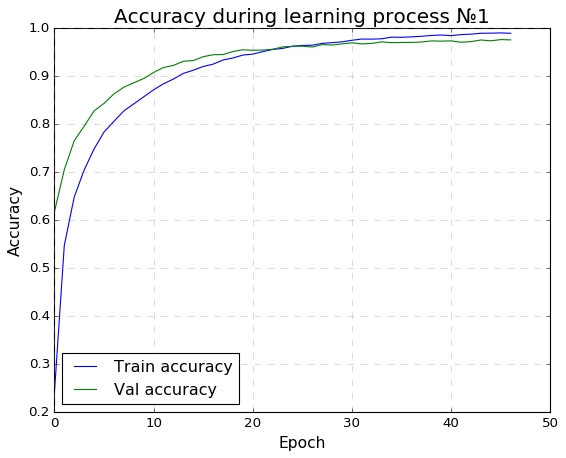

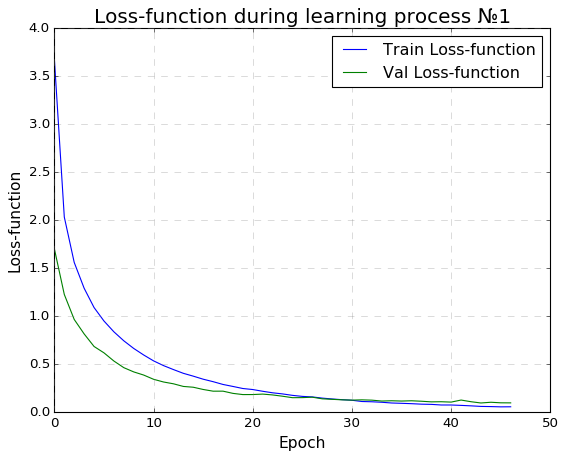

In [ ]:
fig0 = plt.figure(0)
plt.style.use(['classic'])
fig0.set_facecolor('w')

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
plt.title('Accuracy during learning process №1', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best')
fig0.savefig(results_path + '/train1_acc_per_epochs_en.png')

# --------------

fig1 = plt.figure(1)
plt.style.use(['classic'])
fig1.set_facecolor('w')

plt.plot(history.history['loss'], label='Train Loss-function')
plt.plot(history.history['val_loss'], label='Val Loss-function')
plt.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
plt.title('Loss-function during learning process №1', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss-function', fontsize=14)
plt.legend(loc='best')
fig1.savefig(results_path + '/train1_loss_per_epochs_en.png')

In [ ]:
def results_report(data_X, data_Y, save_xlsx_path: str="", batch_size: int=64):
    pred = model.predict(data_X, batch_size=batch_size, verbose=1)

   
    pred_bool = np.argmax(pred, axis=1)

    report = classification_report(np.argmax(data_Y, axis=1), pred_bool, 
                                   output_dict=True)
   
    report_df = pd.DataFrame(report).transpose()

    if save_xlsx_path:  
        try:
            report_df.to_excel(save_xlsx_path, sheet_name='Sheet0')
            print(f"Saved to the: {save_xlsx_path}")
        except Exception as e:
            print('ERROR: Unsuccessfull saving')
            print(e)
    return report_df

In [ ]:
val_report_df = results_report(val_X, val_Y, save_xlsx_path=results_path + 
                               '/train1_val_report_en.xlsx')
print(val_report_df)
val_eval = model.evaluate(val_X, val_Y)
print(f'loss: {round(val_eval[0], 5)}, acc: {round(val_eval[1], 5)}')


9895/9895 [==============================] - 1s 112us/step
Saved to the: /content/drive/My Drive/Colab Notebooks/Results/CourseWork/EN/train1_val_report_en.xlsx
              precision    recall  f1-score      support
0              0.950820  0.935484  0.943089    62.000000
1              0.935484  0.966667  0.950820   120.000000
2              0.984496  0.920290  0.951311   138.000000
3              0.981818  0.947368  0.964286    57.000000
4              1.000000  0.943396  0.970874    53.000000
...                 ...       ...       ...          ...
65             0.983287  0.988796  0.986034   357.000000
66             0.956522  0.846154  0.897959    52.000000
accuracy       0.975038  0.975038  0.975038     0.975038
macro avg      0.967302  0.935768  0.949879  9895.000000
weighted avg   0.975279  0.975038  0.974802  9895.000000

[70 rows x 4 columns]
9895/9895 [==============================] - 1s 132us/step
loss: 0.09402, acc: 0.97504
